In [15]:
from bioinfokit import visuz
import pandas as pd
import numpy as np
import csv
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [16]:
import math
from scipy import stats

In [17]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
# load data
data = pd.read_csv('../data/pos_data_HumanVSBovine.csv')

In [19]:
data_library = pd.read_csv('../data/Positive_Garrett_MetaboliteStd_Library_RP_edited01152019JG.csv')

In [20]:
data_library.head()

,Garrett Lab ID,M/Z,Retention,Name,Formula,Molecular Weight,Adduct,Notes,Unnamed: 8,KEGG,Unnamed: 10
0,428p,75.09170,0.620,"1,3-DIAMINOPROPANE",C3H10N2,74.12490,NaN,NaN,NaN,C00986,NaN
1,750p,76.03930,0.736,GLYCINE,C2H5NO2,75.06660,NaN,NaN,NaN,C00037,NaN
2,2723790p,77.01680,0.908,THIOUREA,CH4N2S,76.12086,NaN,NaN,NaN,C14415,NaN
3,1049p,80.04971,0.973,Pyridine,C5H5N,79.04220,NaN,Shaddox Samples - Compound Discoverer,NaN,C00747,NaN
4,1045p,89.10730,0.580,PUTRESCINE,C4H12N2,88.15148,NaN,RT corrected from 0.63min by std 03.01.2018 CC,NaN,C00134,NaN


In [21]:
def add_ppm(row, library_df):
    if pd.isnull(row['row identity (main ID)']):
        return None
    mzs = list(library_df[library_df.Name.str.strip() == row['row identity (main ID)']]['M/Z'])
    mz_observe = row["row m/z"]
#    print(row['row identity (main ID)'])
#    print(mzs)
    diff = []
    for mz in mzs:
#        print(mz)
        diff.append(abs(mz_observe - mz))
    mz_theoretical = mzs[diff.index(min(diff))]
    return abs((mz_observe-mz_theoretical)*10e6/mz_theoretical)

In [22]:
data["ppm"] = data.apply(lambda row: add_ppm(row, data_library), axis = 1)

In [23]:
len(data)

716

In [11]:
data[data.ppm < 5].to_csv("../../temp/needed.csv", index = False)

In [72]:
data_library[data_library.Name == 'Theobromine']

,Garrett Lab ID,M/Z,Retention,Name,Formula,Molecular Weight,Adduct,Notes,Unnamed: 8,KEGG,Unnamed: 10


In [76]:
data_library.Name.iloc[628].strip()

'Theobromine'

In [24]:
sign_threshold = 0.05/len(data)

In [25]:
sign_threshold

6.983240223463688e-05

In [26]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'row ID', 'row m/z', 'row retention time',
       'row identity (main ID)', 'row identity (all IDs)',
       'row identity (main ID + details)', 'row comment',
       'row number of detected peaks',
       ...
       'label', 'fold_change(bovine versus human)',
       'log2_fold_change(bovine versus human)', 'p_value', 'bovine_zero',
       'human_zero', 'threshold', 'bovine_selected', 'human_selected', 'ppm'],
      dtype='object', length=439)

In [27]:
# load design file
design = pd.read_csv('../data/pos_design_HumanVSBovine.csv')

In [28]:
# data_ref = pd.read_csv('../results/R_outputs/pos_100_withbg_ready.csv')

In [29]:
data.head()

,Unnamed: 0,Unnamed: 0.1,row ID,row m/z,row retention time,row identity (main ID),row identity (all IDs),row identity (main ID + details),row comment,row number of detected peaks,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak status,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak name,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak RT,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak height,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak area,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak charge,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak status,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak name,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak RT,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak height,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak area,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak charge,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak status,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak name,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak RT,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak height,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak area,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak charge,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak status,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak name,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak RT,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak height,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak area,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak charge,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak status,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak name,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak RT,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak height,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak area,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak charge,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak FWHM,QE

In [30]:
pd.isnull(data["row identity (main ID)"].iloc[3])

False

In [31]:
blank_group_name = "zero-blank"

group_names = list(set(design['group']))
group_names.sort()

group1_name = group_names[0]
group2_name = group_names[1]

group1_columns = design[design.group == group1_name].sampleID.tolist()
group2_columns = design[design.group == group2_name].sampleID.tolist()
# sign_threshold = 0.05/len(data)

In [32]:
group1_columns = design[design.group == group1_name].sampleID.tolist()
group2_columns = design[design.group == group2_name].sampleID.tolist()
blank_columns = design[design.group == blank_group_name].sampleID.tolist()

In [33]:
def add_label(row):
    if pd.isnull(row["row identity (main ID)"]):
        return str(round(row["row m/z"],2)) + "/" + str(round(row["row retention time"], 2)) + "/" + str(round(row["fold_change" + "(" + str(group1_name) + " versus " + str(group2_name) + ")"], 2))
    else:
        return str(row["row identity (main ID)"]) + "/" + str(round(row["fold_change" + "(" + str(group1_name) + " versus " + str(group2_name) + ")"], 2))

In [34]:
data['label'] = data.apply(lambda row: add_label(row), axis = 1)

In [467]:
design.head()

,sampleID,group
0,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak height,zero-blank
1,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak height,zero-blank
2,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak height,zero-blank
3,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak height,zero-blank
4,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak height,zero-blank


In [31]:
a = list(set(design['group']))

In [32]:
a.sort()

In [33]:
a

['bovine', 'human', 'zero-blank']

In [10]:
def add_threshold(row, names):
    value = np.mean(row[names]) + 3*np.std(row[names])
    return value if value >0 else 5000 

In [11]:
def blank_subtraction(row, name_group, name_threshold, bar):
    return (np.mean(row[name_group]) - row[name_threshold])/row[name_threshold] > bar

In [12]:
def add_pvalue(row, left_names, right_names):
    t, p = stats.ttest_ind(row[left_names], row[right_names])
    return p

In [12]:
def add_tvalue(row, left_names, right_names):
    t, _ = stats.ttest_ind(row[left_names], row[right_names])
    return t

In [30]:
def fold_change(row, left, right):
    if row[right] == 0:
        return 1024
    elif row[left] == 0:
        return -1024
    else:
        result = row[left]/row[right]
        return result if result >=1 else -1/result

In [436]:
def abs_fold_change(row, fold_change_column):
        return abs(row[fold_change_column])

In [15]:
def log2_fold_change(row, left, right):
    if row[right] == 0:
        return 10
    elif row[left] == 0:
        return -10
    else:
        return math.log2(row[left]/row[right])
#        return result if result >=1 else -1/result

In [14]:
data['threshold'] = data.apply(lambda row: add_threshold(row, blank_columns), axis = 1)

In [59]:
data[str(group1_name) + "_selected"] = data.apply(lambda row: blank_subtraction(row, group1_columns, "threshold", ratio_bar), axis = 1)

In [60]:
data[str(group2_name) + "_selected"] = data.apply(lambda row: blank_subtraction(row, group2_columns, "threshold", ratio_bar), axis = 1)

In [61]:
data[str(group1_name) + "_mean"] = data[group1_columns].mean(axis = 1)

In [62]:
data[str(group2_name) + "_mean"] = data[group2_columns].mean(axis = 1)

In [63]:
data['fold_change' + "(" + str(group1_name) + " versus " + str(group2_name) + ")"] = data.apply(lambda row: fold_change(row, str(group1_name) + "_mean", str(group2_name) + "_mean"), axis = 1)

In [489]:
data['abs_fold_change' + "(" + str(group1_name) + " versus " + str(group2_name) + ")"] = data.apply(lambda row: abs_fold_change(row, 'fold_change' + "(" + str(group1_name) + " versus " + str(group2_name) + ")"), axis = 1)

In [34]:
data['log2_fold_change' + "(" + str(group1_name) + " versus " + str(group2_name) + ")"] = data.apply(lambda row: log2_fold_change(row, str(group1_name) + "_mean", str(group2_name) + "_mean"), axis = 1)

In [64]:
data['log2_fold_change' + "(" + str(group1_name) + " versus " + str(group2_name) + ")"] = np.log2(data[str(group1_name) + "_mean"]/data[str(group2_name) + "_mean"])

In [65]:
data['p_value'] = data.apply(lambda row: add_pvalue(row, group1_columns, group2_columns), axis = 1)

In [35]:
data['t_value'] = data.apply(lambda row: add_tvalue(row, group1_columns, group2_columns), axis = 1)

In [49]:
data_withBS = data[(data.group1_selected == 1) | (data.group2_selected == 1)]

In [50]:
check = data[data["row ID"] == 2598]

In [51]:
(np.mean(check[group1_columns].iloc[0]) - check['threshold'].iloc[0])/check['threshold']

2307    0.636861
Name: threshold, dtype: float64

In [52]:
len(data_withBS)

677

In [36]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

### Two-sample comparison

In [493]:
import copy

In [494]:
# data_matched = data.dropna(subset = ["row identity (main ID)"])
data_matched = both[both.p_value < sign_threshold]
# data_matched = data_matched.dropna(subset = ["row identity (main ID)"])

In [495]:
data_withBS_filtered = copy.deepcopy(data_matched)

In [496]:
n_rows = min(50, 
             len(data_withBS_filtered[data_withBS_filtered.p_value < sign_threshold]))
# n_rows = len(data_withBS_filtered[data_withBS_filtered.p_value < sign_threshold])

In [497]:
n_rows

50

In [498]:
data_withBS_filtered = data_withBS_filtered.sort_values(by = 'abs_fold_change' + "(" + str(group1_name) + " versus " + str(group2_name) + ")", ascending = False).iloc[0:n_rows]
# data_withBS_filtered = data_withBS_filtered.sort_values(by = 'p_value').iloc[0:n_rows]

In [499]:
data_withBS_filtered.index = data_withBS_filtered.label

In [500]:
data_withBS_filtered = data_withBS_filtered[group1_columns + group2_columns]

In [501]:
data_withBS_filtered.head()

,QE2_jdg_242_Lemas_21[LAB_21]p.mzXML Peak height,QE2_jdg_242_Lemas_22[LAB_22]p.mzXML Peak height,QE2_jdg_242_Lemas_23[LAB_23]p.mzXML Peak height,QE2_jdg_242_Lemas_24[LAB_24]p.mzXML Peak height,QE2_jdg_242_Lemas_25[LAB_25]p.mzXML Peak height,QE2_jdg_242_Lemas_26[LAB_26]p.mzXML Peak height,QE2_jdg_242_Lemas_33[LAB_33]p.mzXML Peak height,QE2_jdg_242_Lemas_34[LAB_34]p.mzXML Peak height,QE2_jdg_242_Lemas_35[LAB_35]p.mzXML Peak height,QE2_jdg_242_Lemas_36[LAB_36]p.mzXML Peak height,QE2_jdg_242_Lemas_37[LAB_37]p.mzXML Peak height,QE2_jdg_242_Lemas_38[LAB_38]p.mzXML Peak height
label,,,,,,,,,,,,
157.02/1.19/26.5,9.566423e+07,8.342262e+07,7.047059e+07,7.315848e+07,6.743638e+07,8.444074e+07,2.477020e+06,3.332115e+06,4.986629e+06,2.512737e+06,2.864459e+06,1.733895e+06
212.01/1.92/13.86,1.086391e+07,1.157033e+07,1.131205e+07,1.068975e+07,1.265842e+07,1.106497e+07,5.862869e+05,2.097463e+05,7.670070e+05,9.406748e+05,2.344857e+06,6.756895e+04
263.15/0.89/13.12,1.322273e+07,1.195251e+07,1.335953e+07,1.577680e+07,1.287091e+07,1.349438e+07,1.829700e+05,4.653165e+05,2.114670e+06,9.291159e+05,2.206397e+06,2.490286e+05
N-METHYL-D-ASPARTIC ACID/11.34,5.695839e+07,5.004820e+07,2.441051e+07,7.143406e+07,6.900329e+07,5.351584e+07,2.575020e+06,8.748322e+06,8.444284e+06,2.150681e+06,5.539086e+06,1.246725e+06
Citrate source fragment (+NH3)/11.3,1.059408e+07,1.112777e+07,1.200294e+07,1.014390e+07,1.409272e+07,1.044863e+07,8.583500e+05,5.486384e+05,1.096557e+06,1.189815e+06,2.081645e+06,2.772235e+05


In [502]:
for i, group1_column in enumerate(group1_columns):
    data_withBS_filtered.rename(columns = {group1_column: group1_name + '_' + str(i)}, inplace = True)
for i, group2_column in enumerate(group2_columns):
    data_withBS_filtered.rename(columns = {group2_column: group2_name + '_' + str(i)}, inplace = True)

In [503]:
data_withBS_filtered.head()

,heat_0,heat_1,heat_2,heat_3,heat_4,heat_5,heat_colostrum_0,heat_colostrum_1,heat_colostrum_2,heat_colostrum_3,heat_colostrum_4,heat_colostrum_5
label,,,,,,,,,,,,
157.02/1.19/26.5,9.566423e+07,8.342262e+07,7.047059e+07,7.315848e+07,6.743638e+07,8.444074e+07,2.477020e+06,3.332115e+06,4.986629e+06,2.512737e+06,2.864459e+06,1.733895e+06
212.01/1.92/13.86,1.086391e+07,1.157033e+07,1.131205e+07,1.068975e+07,1.265842e+07,1.106497e+07,5.862869e+05,2.097463e+05,7.670070e+05,9.406748e+05,2.344857e+06,6.756895e+04
263.15/0.89/13.12,1.322273e+07,1.195251e+07,1.335953e+07,1.577680e+07,1.287091e+07,1.349438e+07,1.829700e+05,4.653165e+05,2.114670e+06,9.291159e+05,2.206397e+06,2.490286e+05
N-METHYL-D-ASPARTIC ACID/11.34,5.695839e+07,5.004820e+07,2.441051e+07,7.143406e+07,6.900329e+07,5.351584e+07,2.575020e+06,8.748322e+06,8.444284e+06,2.150681e+06,5.539086e+06,1.246725e+06
Citrate source fragment (+NH3)/11.3,1.059408e+07,1.112777e+07,1.200294e+07,1.014390e+07,1.409272e+07,1.044863e+07,8.583500e+05,5.486384e+05,1.096557e+06,1.189815e+06,2.081645e+06,2.772235e+05


### Hierachical Clustering

In [504]:
import seaborn as sns; sns.set(color_codes=True)

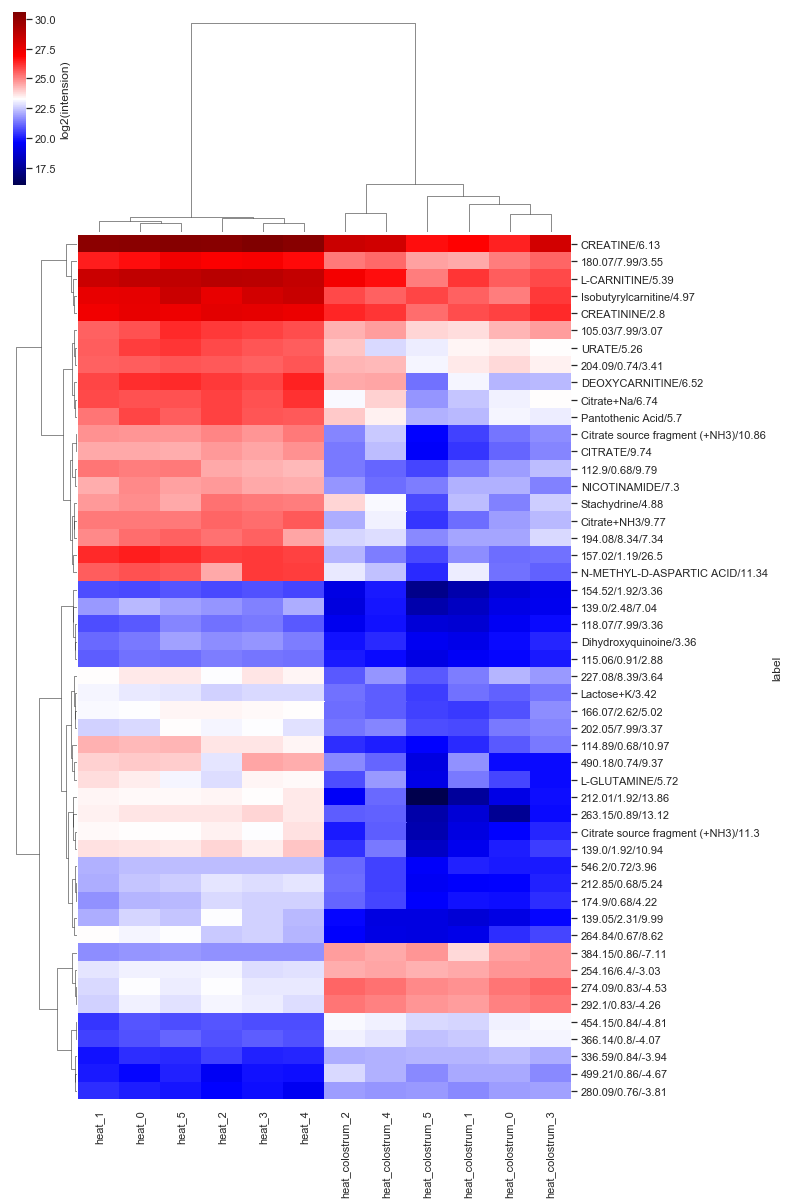

In [505]:
g = sns.clustermap(np.log2(data_withBS_filtered + 1), figsize = (10, 20), xticklabels=True, yticklabels=True, cmap = "seismic", cbar_kws={'label': 'log2(intension)'}, method = 'ward')
# plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)

In [127]:
g.savefig("test.png")

### PCA

In [63]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [64]:
# Plot PCA with confidence ellipse

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`
    
    See how and why this works: https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html
    
    This function has made it into the matplotlib examples collection:
    https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html#sphx-glr-gallery-statistics-confidence-ellipse-py
    
    Or, once matplotlib 3.1 has been released:
    https://matplotlib.org/gallery/index.html#statistics
    
    I update this gist according to the version there, because thanks to the matplotlib community
    the code has improved quite a bit.
    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    Returns
    -------
    matplotlib.patches.Ellipse
    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
#    return ellipse
    return ax.add_patch(ellipse)

In [65]:
x = data_withBS_filtered.as_matrix().T
x = StandardScaler().fit_transform(x)

In [66]:
pca = PCA(n_components=min(x.shape))
principalComponents = pca.fit_transform(x)
columns_components = []
for i in range(pca.n_components_):
    columns_components.append('principal component ' + str(i+1))

In [67]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = columns_components)

In [70]:
target_data = {"label": [group1_name] * len(group1_columns) + [group2_name] * len(group2_columns)}

In [71]:
target_df = pd.DataFrame(target_data)

In [72]:
final_df = pd.concat([principalDf, target_df.label], axis = 1)

In [73]:
final_df

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,principal component 11,principal component 12,principal component 13,principal component 14,principal component 15,principal component 16,principal component 17,principal component 18,principal component 19,principal component 20,label
0,5.864999,-0.644361,-1.185602,0.081767,-0.170186,0.317127,-0.380223,0.236875,-0.247867,0.342079,0.259399,0.170974,0.175059,-0.011540,-0.012495,-0.043786,0.021850,0.016119,0.008695,5.005534e-16,bovine
1,5.928160,-0.130078,-0.123636,-0.416952,1.143982,0.189316,-0.527909,-0.350425,0.246610,-0.051373,-0.154474,-0.219762,0.141374,-0.034624,-0.000687,-0.042404,-0.009378,0.010220,-0.002368,5.005534e-16,bovine
2,6.743264,-1.452829,-0.181516,1.045888,-0.129171,-0.325279,-0.038583,-0.418705,-0.271216,-0.213319,-0.143416,-0.011328,-0.111793,-0.001784,0.020433,0.009528,0.005088,-0.010436,-0.010635,5.005534e-16,bovine
3,8.058075,0.849833,-0.769070,-0.537191,0.013542,0.250612,0.767228,-0.174340,-0.530108,0.027502,-0.129001,-0.139217,-0.039342,0.034791,0.008815,0.031657,-0.030367,-0.014253,0.000256,5.005534e-16,bovine
4,7.391651,-0.306411,-0.619739,-0.386560,-0.864419,0.216014,0.078035,-0.031129,0.703103,-0.139873,0.149515,-0.151259,-0.115885,-0.016417,0.012282,0.036015,0.000390,-0.002929,-0.006067,5.005534e-16,bovine
5,6.802471,1.603451,-0.321816,1.200224,0.422183,-0.147515,0.075497,0.330500,0.246194,-0.098301,0.069713,0.018679,-0.008830,0.007940,0.003949,-0.008536,0.007756,-0.002443,-0.002549,5.005534e-16,bovine
6,6.886879,0.579603,1.370575,0.156605,-0.570095,0.959828,-0.383330,-0.137655,-0.179466,-0.071835,-0.033268,0.075860,0.036392,-0.013873,0.000592,-0.002981,0.005761,-0.005301,0.001377,5.005534e-16,bovine
7,8.174390,0.306100,0.457483,-0.400419,-0.003924,-0.658463,0.297572,-0.416602,0.240130,0.231097,-0.048025,0.396259,-0.001579,-0.020614,-0.028033,-0.028186,0.011332,0.012340,0.010081,5.005534e-16,bovine
8,6.661797,-0.629922,0.723545,-0.000943,-0.169571,-0.339061,0.084243,0.619628,0.062741,0.338189,-0.357888,-0.188014,0.071970,0.032270,-0.001795,0.035372,-0.017341,0.002160,0.005337,5.005534e-16,bovine
9,6.801873,-0.424349,0.641486,-0.627272,0.483038,-0.340043,-0.052740,0.402561,-0.254751,-0.355967,0.409867,0.030408,-0.113467,0.022774,-0.000795,0.008265,0.010347,-0.003254,-0.003350,5.005534e-16,bovine


In [74]:
x_group1 = final_df[final_df.label == group1_name]["principal component 1"].as_matrix()
y_group1 = final_df[final_df.label == group1_name]["principal component 2"].as_matrix()
x_group2 = final_df[final_df.label == group2_name]["principal component 1"].as_matrix()
y_group2 = final_df[final_df.label == group2_name]["principal component 2"].as_matrix()

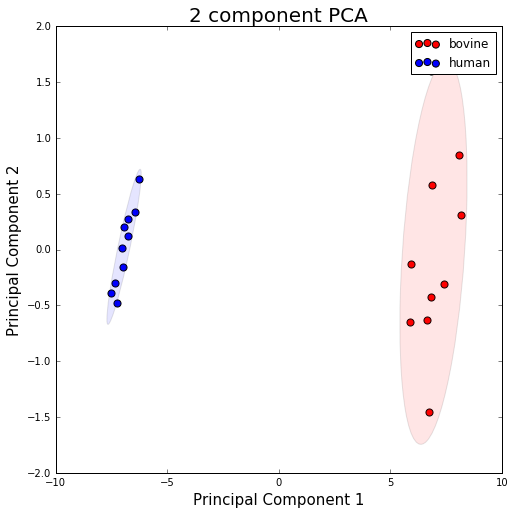

In [75]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [group1_name, group2_name]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['label'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'principal component 1']
               , final_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
# ax.set_xlim(-50, 50)
# ax.set_ylim(-50, 50)
confidence_ellipse(x_group1, y_group1, ax, n_std = 1.96, facecolor = "r", alpha = 0.1)
confidence_ellipse(x_group2, y_group2, ax, n_std = 1.96, facecolor = "b", alpha = 0.1)
ax.grid()

## PLS-DA

In [58]:
from sklearn.cross_decomposition import PLSRegression

In [42]:
data_withBS_filtered.head()

,fat_0,fat_1,fat_2,fat_3,skim_0,skim_1,skim_2,skim_3
label,,,,,,,,
PHOSPHOCHOLINE,7.172997e+08,1.407830e+09,5.269804e+08,4.318398e+08,1.506514e+09,1.317603e+09,8.507828e+08,1.121725e+09
Glycerophosphocholine,4.594217e+08,7.791556e+08,3.869271e+08,2.544940e+08,8.114799e+08,7.673914e+08,6.673932e+08,7.154476e+08
L-CARNITINE,4.691478e+08,7.961944e+08,3.046261e+08,2.121236e+08,8.994626e+08,9.883137e+08,7.963888e+08,7.219592e+08
204.12/5.49,7.869766e+07,8.456591e+07,6.879737e+07,0.000000e+00,9.363446e+07,1.159167e+08,1.388494e+08,1.110957e+08
204.12/5.55,7.661319e+07,8.444182e+07,6.864606e+07,5.289199e+07,9.511251e+07,1.037598e+08,1.209267e+08,9.832158e+07


In [46]:
data_withBS_filtered.reset_index(drop = True, inplace = True)

In [47]:
data_withBS_filtered.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828
fat_0,7.172997e+08,4.594217e+08,4.691478e+08,7.869766e+07,7.661319e+07,7.986729e+07,2.104484e+08,3.356834e+08,1.568620e+08,1.943015e+08,2.080441e+08,2.062385e+08,9.955198e+07,56321752.0,3.933086e+07,1.865868e+08,7.269039e+07,1.259985e+08,7.101061e+07,9.593418e+07,5.718253e+07,1.079431e+08,2.980170e+07,3.234008e+07,9.687320e+07,7.027446e+07,1.062600e+08,8.754667e+07,5.292167e+07,4.951844e+07,3.584237e+07,0.000000e+00,3.780731e+07,3.802536e+07,2.770520e+07,1.121702e+07,2.587853e+07,27880518.0,5.754421e+07,3.211289e+07,3.728530e+07,4.651891e+07,3.625292e+07,5.415610e+07,2.676328e+07,5.146060e+07,5.062116e+07,9.044843e+07,4.010198e+07,3.153513e+07,2.926126e+07,7.327529e+06,1.721898e+07,2.954406e+07,2.865132e+07,2.613863e+07,7321140.5,1.186062e+07,4.335666e+07,2.262316e+07,1.222977e+07,2.788782e+07,2.419538e+07,3.226901e+07,2.209922e+07,3.538315e+07,2.122066e+07,2.242204e+07,2.961685e+07,2.924372e+07,2.853557e+07,1.947115e+07,1.735199e+07,2.414099e+07,9.699308e+06,4.999564e+06,7.664107e+06,1.444130e+07,1.321758e+07,1.808498e+07,8.250828e+06,1.602842e+07,1.113116e+07,2.107122e+06,2.820356e+07,1.724596e+07,1.303537e+07,3.302554e+06,1.921686e+07,3.366110e+06,1.378508e+07,8.591317e+06,6.301429e+06,1.638510e+07,4.420453e+06,1.896583e+07,0.000000e+00,1.097419e+07,2.562791e+06,6.241220e+06,1.260961e+07,5.537364e+06,9.512220e+06,1.069299e+07,4571708.00,6.621273e+06,1.923781e+06,4.135362e+06,7.023172e+06,1.488867e+07,11145249.0,6.161018e+06,1.440314e+07,2.818498e+07,1.043173e+07,7.007061e+06,1.379014e+07,9.689970e+06,9.483971e+06,8.294240e+06,8.514638e+06,1.437608e+07,9.068285e+06,1.743873e+06,2.143040e+07,2.744274e+06,5.691843e+06,1.221777e+07,8006747.50,1.201531e+07,5.212962e+06,2.013795e+06,1.447538e+06,7.651135e+06,2583583.750,1.023869e+07,5.756610e+05,5015562.50,1.263240e+07,3.497249e+07,5037650.50,8.493953e+06,8.306112e+06,3.702175e+06,1.009996e+07,6.392789e+06,2.028478e+06,3.637404e+07,5.982422e+06,2.362057e+07,3.660820e+06,2.123981e+06,7.083347e+06,8.191558e+06,7922453.0,2.020143e+06,16539969.0,3.954878e+06,6.804392e+06,1.060810e+07,3.784173e+06,5.995795e+06,2.062222e+06,7.1

In [52]:
data_withBS_filtered = data_withBS_filtered.T

In [54]:
data_withBS_filtered["label"] = data_withBS_filtered.index

In [55]:
data_withBS_filtered.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,label
fat_0,7.172997e+08,4.594217e+08,4.691478e+08,7.869766e+07,7.661319e+07,7.986729e+07,2.104484e+08,3.356834e+08,1.568620e+08,1.943015e+08,2.080441e+08,2.062385e+08,9.955198e+07,56321752.0,3.933086e+07,1.865868e+08,7.269039e+07,1.259985e+08,7.101061e+07,9.593418e+07,5.718253e+07,1.079431e+08,2.980170e+07,3.234008e+07,9.687320e+07,7.027446e+07,1.062600e+08,8.754667e+07,5.292167e+07,49518440.00,3.584237e+07,0.000000e+00,3.780731e+07,3.802536e+07,2.770520e+07,1.121702e+07,2.587853e+07,27880518.0,5.754421e+07,3.211289e+07,3.728530e+07,4.651891e+07,3.625292e+07,5.415610e+07,2.676328e+07,5.146060e+07,5.062116e+07,9.044843e+07,4.010198e+07,3.153513e+07,2.926126e+07,7.327529e+06,1.721898e+07,2.954406e+07,2.865132e+07,2.613863e+07,7321140.5,1.186062e+07,4.335666e+07,2.262316e+07,1.222977e+07,2.788782e+07,2.419538e+07,3.226901e+07,2.209922e+07,3.538315e+07,2.122066e+07,2.242204e+07,2.961685e+07,2.924372e+07,2.853557e+07,1.947115e+07,1.735199e+07,2.414099e+07,9.699308e+06,4.999564e+06,7.664107e+06,1.444130e+07,1.321758e+07,1.808498e+07,8.250828e+06,1.602842e+07,1.113116e+07,2.107122e+06,2.820356e+07,1.724596e+07,1.303537e+07,3.302554e+06,1.921686e+07,3.366110e+06,1.378508e+07,8.591317e+06,6.301429e+06,1.638510e+07,4.420453e+06,1.896583e+07,0.0,1.097419e+07,2.562791e+06,6.241220e+06,1.260961e+07,5.537364e+06,9.512220e+06,1.069299e+07,4571708.00,6.621273e+06,1.923781e+06,4.135362e+06,7.023172e+06,1.488867e+07,11145249.0,6.161018e+06,1.440314e+07,2.818498e+07,1.043173e+07,7.007061e+06,1.379014e+07,9.689970e+06,9.483971e+06,8.294240e+06,8.514638e+06,1.437608e+07,9.068285e+06,1.743873e+06,2.143040e+07,2.744274e+06,5.691843e+06,1.221777e+07,8006747.50,1.201531e+07,5.212962e+06,2.013795e+06,1.447538e+06,7.651135e+06,2583583.750,1.023869e+07,5.756610e+05,5015562.50,1.263240e+07,3.497249e+07,5037650.50,8.493953e+06,8.306112e+06,3.702175e+06,1.009996e+07,6.392789e+06,2.028478e+06,3.637404e+07,5.982422e+06,2.362057e+07,3.660820e+06,2.123981e+06,7.083347e+06,8.191558e+06,7922453.0,2.020143e+06,16539969.0,3.954878e+06,6.804392e+06,1.060810e+07,3.784173e+06,5.995795e+06,2.062222e+06,7.115857e+0

In [56]:
data_withBS_filtered.reset_index(drop = True, inplace = True)

In [57]:
data_withBS_filtered.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,label
0,7.172997e+08,4.594217e+08,4.691478e+08,7.869766e+07,7.661319e+07,7.986729e+07,2.104484e+08,3.356834e+08,1.568620e+08,1.943015e+08,2.080441e+08,2.062385e+08,9.955198e+07,56321752.0,3.933086e+07,1.865868e+08,7.269039e+07,1.259985e+08,7.101061e+07,9.593418e+07,5.718253e+07,1.079431e+08,2.980170e+07,3.234008e+07,9.687320e+07,7.027446e+07,1.062600e+08,8.754667e+07,5.292167e+07,49518440.00,3.584237e+07,0.000000e+00,3.780731e+07,3.802536e+07,2.770520e+07,1.121702e+07,2.587853e+07,27880518.0,5.754421e+07,3.211289e+07,3.728530e+07,4.651891e+07,3.625292e+07,5.415610e+07,2.676328e+07,5.146060e+07,5.062116e+07,9.044843e+07,4.010198e+07,3.153513e+07,2.926126e+07,7.327529e+06,1.721898e+07,2.954406e+07,2.865132e+07,2.613863e+07,7321140.5,1.186062e+07,4.335666e+07,2.262316e+07,1.222977e+07,2.788782e+07,2.419538e+07,3.226901e+07,2.209922e+07,3.538315e+07,2.122066e+07,2.242204e+07,2.961685e+07,2.924372e+07,2.853557e+07,1.947115e+07,1.735199e+07,2.414099e+07,9.699308e+06,4.999564e+06,7.664107e+06,1.444130e+07,1.321758e+07,1.808498e+07,8.250828e+06,1.602842e+07,1.113116e+07,2.107122e+06,2.820356e+07,1.724596e+07,1.303537e+07,3.302554e+06,1.921686e+07,3.366110e+06,1.378508e+07,8.591317e+06,6.301429e+06,1.638510e+07,4.420453e+06,1.896583e+07,0.0,1.097419e+07,2.562791e+06,6.241220e+06,1.260961e+07,5.537364e+06,9.512220e+06,1.069299e+07,4571708.00,6.621273e+06,1.923781e+06,4.135362e+06,7.023172e+06,1.488867e+07,11145249.0,6.161018e+06,1.440314e+07,2.818498e+07,1.043173e+07,7.007061e+06,1.379014e+07,9.689970e+06,9.483971e+06,8.294240e+06,8.514638e+06,1.437608e+07,9.068285e+06,1.743873e+06,2.143040e+07,2.744274e+06,5.691843e+06,1.221777e+07,8006747.50,1.201531e+07,5.212962e+06,2.013795e+06,1.447538e+06,7.651135e+06,2583583.750,1.023869e+07,5.756610e+05,5015562.50,1.263240e+07,3.497249e+07,5037650.50,8.493953e+06,8.306112e+06,3.702175e+06,1.009996e+07,6.392789e+06,2.028478e+06,3.637404e+07,5.982422e+06,2.362057e+07,3.660820e+06,2.123981e+06,7.083347e+06,8.191558e+06,7922453.0,2.020143e+06,16539969.0,3.954878e+06,6.804392e+06,1.060810e+07,3.784173e+06,5.995795e+06,2.062222e+06,7.115857e+06,6.

In [62]:
y = np.array(data_withBS_filtered.label)

In [69]:
y

array(['fat_0', 'fat_1', 'fat_2', 'fat_3', 'skim_0', 'skim_1', 'skim_2',
       'skim_3'], dtype=object)

In [71]:
y[0:4] = 0

In [72]:
y[4:] = 1

In [66]:
X = data_withBS_filtered.loc[:, data_withBS_filtered.columns != "label"].values

In [67]:
plsr = PLSRegression(n_components=2, scale=False)

In [74]:
plsr.fit(X, y)

PLSRegression(copy=True, max_iter=500, n_components=2, scale=False, tol=1e-06)

In [78]:
colorlist = ['r', 'r', 'r', 'r', 'b', 'b', 'b', 'b']

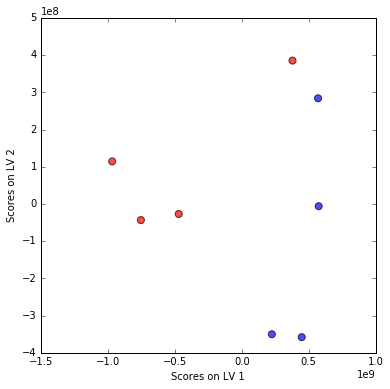

In [79]:
scores = pd.DataFrame(plsr.x_scores_)
scores.index=data_withBS_filtered.index

ax = scores.plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, 
                 c=colorlist, figsize=(6,6))
ax.set_xlabel('Scores on LV 1')
ax.set_ylabel('Scores on LV 2')

## Venn Diagram

In [166]:
data.head()

,Unnamed: 0,Unnamed: 0.1,row ID,row m/z,row retention time,row identity (main ID),row identity (all IDs),row identity (main ID + details),row comment,row number of detected peaks,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak status,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak name,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak RT,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak height,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak area,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak charge,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak status,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak name,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak RT,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak height,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak area,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak charge,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak status,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak name,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak RT,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak height,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak area,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak charge,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak status,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak name,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak RT,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak height,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak area,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak charge,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak status,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak name,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak RT,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak height,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak area,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak charge,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak FWHM,QE

In [37]:
from matplotlib_venn import venn2 

In [38]:
group1_name

'bovine'

In [39]:
only_group1 = data[(data[str(group1_name) + "_selected"] == True) & (data[str(group2_name) + "_selected"] == False)]
only_group2 = data[(data[str(group1_name) + "_selected"] == False) & (data[str(group2_name) + "_selected"] == True)]
both = data[(data[str(group1_name) + "_selected"] == True) & (data[str(group2_name) + "_selected"] == True)]

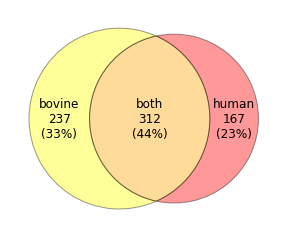

In [40]:
# df = pd.DataFrame({'Product': ['Only cheese', 'Only red wine', 'Both'],
#                    'NbClient': [900, 1200, 400]},
#                   columns = ['Product', 'NbClient'])

v2 = venn2(subsets = {'10': len(only_group1),
                      '01': len(only_group2),
                      '11': len(both)},
           set_labels=('', ''))
v2.get_patch_by_id('10').set_color('yellow')
v2.get_patch_by_id('01').set_color('red')
v2.get_patch_by_id('11').set_color('orange')

v2.get_patch_by_id('10').set_edgecolor('black')
v2.get_patch_by_id('01').set_edgecolor('black')
v2.get_patch_by_id('11').set_edgecolor('black')

v2.get_label_by_id('10').set_text('%s\n%d\n(%.0f%%)' % (group1_name,
                                                        len(only_group1),
                                                        len(only_group1)*100/len(data)))

v2.get_label_by_id('01').set_text('%s\n%d\n(%.0f%%)' % (group2_name,
                                                        len(only_group2),
                                                        len(only_group2)*100/len(data)))

v2.get_label_by_id('11').set_text('%s\n%d\n(%.0f%%)' % ("both",
                                                        len(both),
                                                        len(both)*100/len(data)))

for text in v2.subset_labels:
    text.set_fontsize(12)

plt.show()

## Bap Plot

In [240]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'row ID', 'row m/z', 'row retention time',
       'row identity (main ID)', 'row identity (all IDs)',
       'row identity (main ID + details)', 'row comment',
       'row number of detected peaks',
       ...
       'label', 'fold_change(heat versus heat_colostrum)',
       'log2_fold_change(heat versus heat_colostrum)', 'p_value', 'heat_zero',
       'heat_colostrum_zero', 'threshold', 'heat_selected',
       'heat_colostrum_selected', 't_value'],
      dtype='object', length=311)

In [241]:
data.head()

,Unnamed: 0,Unnamed: 0.1,row ID,row m/z,row retention time,row identity (main ID),row identity (all IDs),row identity (main ID + details),row comment,row number of detected peaks,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak status,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak name,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak RT,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak height,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak area,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak charge,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak status,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak name,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak RT,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak height,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak area,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak charge,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak status,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak name,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak RT,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak height,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak area,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak charge,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak status,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak name,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak RT,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak height,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak area,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak charge,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak status,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak name,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak RT,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak height,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak area,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak charge,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_2[extBlank]p.mzXML Peak FWHM,QE

In [316]:
# data_matched = data.dropna(subset = ["row identity (main ID)"])
# data_matched = both.dropna(subset = ["row identity (main ID)"])
data_matched = both
data_matched_sign = data_matched[data_matched.p_value < sign_threshold]

Text(0.5,1,'Log2 Mean Fold Change (bovine versus human)')

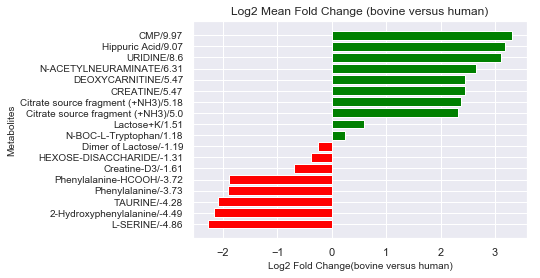

In [300]:
fold_change_sorted = data_matched_sign.sort_values(by=['fold_change' + "(" + str(group1_name) + " versus " + str(group2_name) + ")"])
n_pos = min(10, len(data_matched_sign[data_matched_sign['fold_change' + "(" + str(group1_name) + " versus " + str(group2_name) + ")"]>=0]))
n_neg = min(10, len(data_matched_sign[data_matched_sign['fold_change' + "(" + str(group1_name) + " versus " + str(group2_name) + ")"]<0]))
names = fold_change_sorted.label[0:n_pos].tolist() + fold_change_sorted.label[-n_neg:].tolist()
values = fold_change_sorted['log2_fold_change' + "(" + str(group1_name) + " versus " + str(group2_name) + ")"][0:n_pos].tolist() + fold_change_sorted['log2_fold_change' + "(" + str(group1_name) + " versus " + str(group2_name) + ")"][-n_neg:].tolist()

index = np.arange(len(names))
plt.barh(names, values, color = ["red"] * n_neg + ["green"] * n_pos)
plt.xlabel('Log2 Fold Change' + "(" + str(group1_name) + " versus " + str(group2_name) + ")", fontsize=10)
plt.ylabel('Metabolites', fontsize=10)
plt.yticks(index, names, fontsize=10)
plt.title("Log2 Mean Fold Change"  + " (" + str(group1_name) + " versus " + str(group2_name) + ")")

In [36]:
fold_change_sorted.head()

,Unnamed: 0,Unnamed: 0.1,row ID,row m/z,row retention time,row identity (main ID),row identity (all IDs),row identity (main ID + details),row comment,row number of detected peaks,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak status,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak name,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak RT,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak height,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak area,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak charge,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak status,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak name,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak RT,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak height,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak area,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak charge,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak status,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak name,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak RT,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak height,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak area,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak charge,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak status,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak name,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak RT,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak height,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak area,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak charge,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak status,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak name,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak RT,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak height,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak area,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak charge,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak FWHM,QE

In [43]:
values

[-inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 -inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf]

## Other Stats

In [28]:
data.head()

,Unnamed: 0,row ID,row m/z,row retention time,row identity (main ID),row identity (all IDs),row identity (main ID + details),row comment,row number of detected peaks,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak status,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak name,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak RT,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak height,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak area,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak charge,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_1[extBlank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak status,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak name,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak RT,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak height,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak area,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak charge,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_6[extBlank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak status,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak name,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak RT,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak height,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak area,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak charge,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_3[extBlank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak status,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak name,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak RT,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak height,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak area,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak charge,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak FWHM,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak tailing factor,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak asymmetry factor,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak m/z min,QE2_jdg_242_Lemas_4[extBlank]p.mzXML Peak m/z max,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak status,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak name,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak m/z,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak RT,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak RT start,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak RT end,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak duration time,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak height,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak area,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak charge,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak # data points,QE2_jdg_242_Lemas_5[extBlank]p.mzXML Peak FWHM,QE2_jdg_242_Lem

In [29]:
len(data)

716

In [31]:
data_withmatch = data[data["row identity (main ID)"].notnull()]

In [33]:
metabolites = list(data_withmatch["row identity (main ID)"])

In [36]:
len(set(metabolites))

103

In [37]:
data_withmatch_sign = data_withmatch[data_withmatch.p_value < 0.05]

In [38]:
metabolites_sign = list(data_withmatch_sign["row identity (main ID)"])

In [40]:
len(set(metabolites_sign))

73

In [43]:
len(set(list(data_withmatch_sign[data_withmatch_sign.fold_change > 0]["row identity (main ID)"])))

51

## mummichog

In [51]:
data_formummichog = both[["row m/z", "row retention time", "p_value", "t_value", "label"]]

In [52]:
data_formummichog.rename(columns = {"row m/z": "m/z", "row retention time": "retention_time", "p_value": "p-value", "t_value": "t-score", "label": "custom_id"}, inplace = True)

In [53]:
data_formummichog.to_csv("../../temp/milk.txt", index = False, sep = "\t")

In [54]:
len(data)

716

In [55]:
sign_threshold

6.983240223463688e-05

In [56]:
len(both)

312